## Case 01: Variational Autoencoder (VAE)
* Dataset: CIFAR100
* DL Framework: Tensorflow-Keras
* DL Task: Image reconstruction

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`OBJECTIVE` Achieve a min. validation accuracy of <b>90%</b> within <b>10 epochs</b>.
<br>`WARNING` Do <b>NOT</b> change any codes in the <i>config.ipynb</i> file.

### Import libraries

In [154]:
from ipynb.fs.full.config import init, load_cifar_100_data, accuracy, show_reconstructions
#TODO: please import other necessary libraries here
import keras
from tensorflow import random as tf_random
from keras.layers import Conv2D
import numpy as np
from numpy import random as np_random

In [155]:
# copying from config, because fail to load from config.ipynb

from keras.datasets import cifar100
from keras.layers import Layer
from keras.metrics import binary_accuracy as ba
from tensorflow import shape as tf_shape, round as tf_round
from matplotlib import pyplot as plt
from numpy import float32


def init():
    return {"EPOCH": 10, "SEED": 42}


def load_cifar_100_data():
    (X_train_full, y_train_full), (X_test, y_test) = cifar100.load_data()
    X_train_full, X_test = X_train_full.astype(float32) / 255, X_test.astype(float32) / 255
    X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
    y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)


def accuracy(y_true, y_pred):
    return ba(tf_round(y_true), tf_round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Load the dataset

In [156]:
(X_train, _), (X_valid, _), (_, _) = load_cifar_100_data()
print(X_train.shape, X_valid.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


Try to show the first 25 images

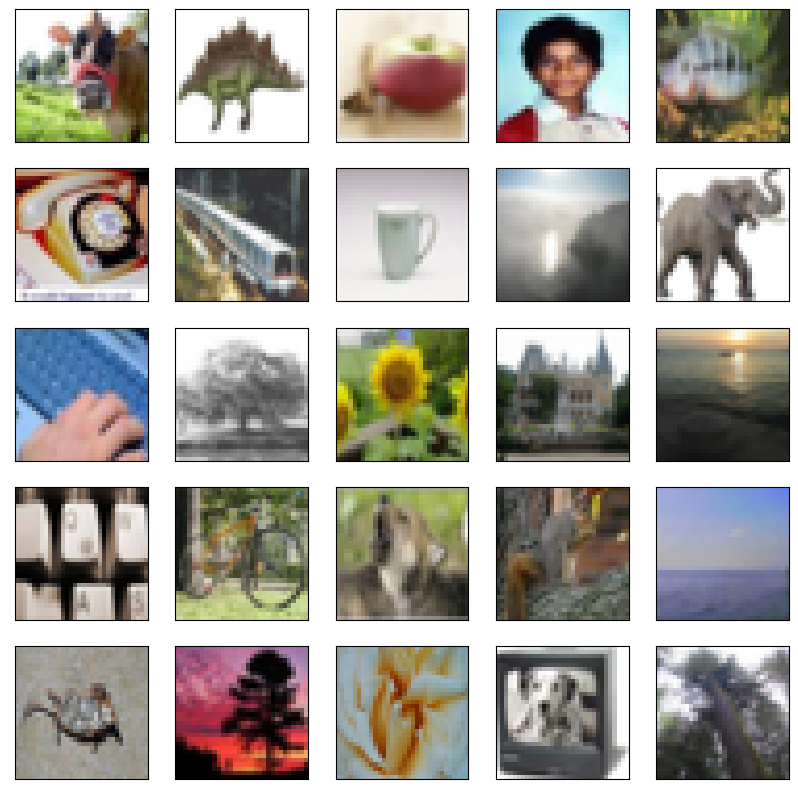

In [157]:
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)

plt.show()

### Configure the hyperparameters

In [158]:
EPOCH = init()["EPOCH"] # DO NOT CHANGE THIS
SEED = init()["SEED"] # DO NOT CHANGE THIS
BATCH_SIZE = 1000 #TODO: set hyperparameters (int)
CODINGS_SIZE = 20 #TODO: set parameters for the latent space representation (int)
LEARNING_RATE = 1e-4 #TODO: set hyperparameters (int)
IMG_SIZE = 32 #TODO: define the image size

In [159]:

K = keras.backend
tf_random.set_seed(SEED) # for reproduciable results
np_random.seed(SEED) # for reproduciable results

### Define the Model

In [160]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf_shape(log_var)) * K.exp(log_var / 2) + mean 

In [161]:
def encoder(i, c, *args, **kwargs):
    """
    function name:
        encoder() = to compress the image inputs (latent)
    function parameters:
        i = image size
        c = coding size
    """
    inputs = keras.layers.Input(shape=[i, i, 3])
    #TODO: define the layers stack for the encoder part. you may use MLP, LSTM, or CNN.
    # variable 'z' will be the first layer
    z = keras.layers.Flatten()(inputs)
    z = keras.layers.Dense(units=5, activation="relu")(z)

    codings_mean = keras.layers.Dense(c)(z)
    codings_log_var = keras.layers.Dense(c)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    return keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]), inputs, codings_mean, codings_log_var

In [162]:
def decoder(i, c, *args, **kwargs):
    """
    function name:
        decoder = to reconstruct the image (with the same size) from the compressed version (latent)
    function parameters:
        i = image size
        c = coding size
    """
    decoder_inputs = keras.layers.Input(shape=c)
    #TODO: define the layers stack for the decoder part. you may use MLP, LSTM, or CNN.
    # variable 'x' will be the first layer
    x = keras.layers.Dense(units=5, activation="relu")(decoder_inputs)
    x = keras.layers.Dense(units=5 ,activation="relu")(x)
    x = keras.layers.Dense(units=(i*i*3) ,activation="relu")(x)

    
    outputs = keras.layers.Reshape(target_shape=[i, i, 3])(x)
    return keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

In [163]:
variational_encoder, inputs, codings_mean, codings_log_var = encoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_encoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 flatten_6 (Flatten)            (None, 3072)         0           ['input_25[0][0]']               
                                                                                                  
 dense_65 (Dense)               (None, 5)            15365       ['flatten_6[0][0]']              
                                                                                                  
 dense_66 (Dense)               (None, 20)           120         ['dense_65[0][0]']               
                                                                                           

In [164]:
variational_decoder = decoder(i=IMG_SIZE, c=CODINGS_SIZE)
variational_decoder.summary() # keep the trainable params below 20,000 is advised

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_68 (Dense)            (None, 5)                 105       
                                                                 
 dense_69 (Dense)            (None, 5)                 30        
                                                                 
 dense_70 (Dense)            (None, 3072)              18432     
                                                                 
 reshape_16 (Reshape)        (None, 32, 32, 3)         0         
                                                                 
Total params: 18,567
Trainable params: 18,567
Non-trainable params: 0
_________________________________________________________________


In [165]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / (np.prod(IMG_SIZE)))

### Compile the model

In [166]:
#TODO: define your loss function, optimizer, and metric
...
variational_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    , loss=keras.losses.MeanAbsoluteError()
    , metrics=[keras.metrics.BinaryAccuracy()]
)

### Train the model
* <b>Bechmark:</b> Validation accuracy fell at `91.48%` within 10 epochs.
* If you encounter this `WARNING:tensorflow:AutoGraph ...` in the first epoch, please ignore.

In [167]:
history = variational_ae.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_valid, X_valid))

Epoch 1/10
45/45 [==============================] - 4s 65ms/step - loss: 0.4682 - binary_accuracy: 0.0037 - val_loss: 0.4628 - val_binary_accuracy: 0.0038
Epoch 2/10
45/45 [==============================] - 2s 54ms/step - loss: 0.4592 - binary_accuracy: 0.0037 - val_loss: 0.4528 - val_binary_accuracy: 0.0038
Epoch 3/10
45/45 [==============================] - 3s 56ms/step - loss: 0.4482 - binary_accuracy: 0.0037 - val_loss: 0.4410 - val_binary_accuracy: 0.0038
Epoch 4/10
45/45 [==============================] - 3s 58ms/step - loss: 0.4345 - binary_accuracy: 0.0037 - val_loss: 0.4253 - val_binary_accuracy: 0.0038
Epoch 5/10
45/45 [==============================] - 3s 60ms/step - loss: 0.4191 - binary_accuracy: 0.0037 - val_loss: 0.4102 - val_binary_accuracy: 0.0038
Epoch 6/10
45/45 [==============================] - 3s 60ms/step - loss: 0.4033 - binary_accuracy: 0.0037 - val_loss: 0.3945 - val_binary_accuracy: 0.0038
Epoch 7/10
45/45 [==============================] - 3s 56ms/step - los

### Visualize training and validation results

Example output:

![VAE_acc_loss](img/vae_plot.png)

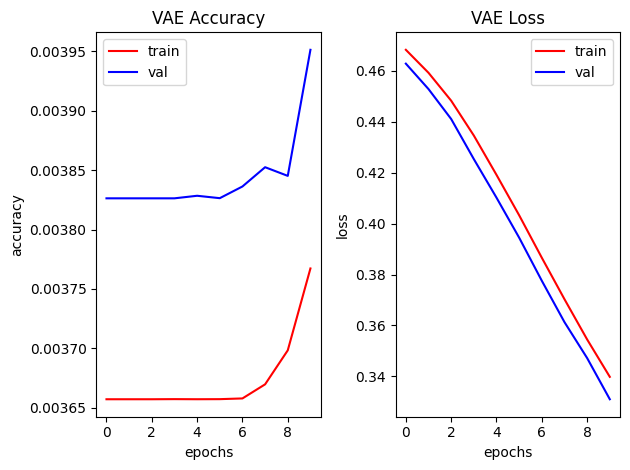

In [168]:
#TODO: plot the loss and accuracy results from both training and validation, as depicted in the image above
...
history_dict = history.history

train_loss = history_dict["loss"]
train_accuracy = history_dict["binary_accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_binary_accuracy"]

epochs = range(0, len(train_loss))

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, train_accuracy, color="r", label="train")
ax[0].plot(epochs, val_accuracy, color="b", label="val")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].set_title("VAE Accuracy")
ax[0].legend()

ax[1].plot(epochs,train_loss, color="r", label="train")
ax[1].plot(epochs, val_loss, color="b", label="val")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("VAE Loss")
ax[1].legend()

plt.tight_layout()
plt.show()




### Test the model

1/1 [==============================] - 0s 111ms/step


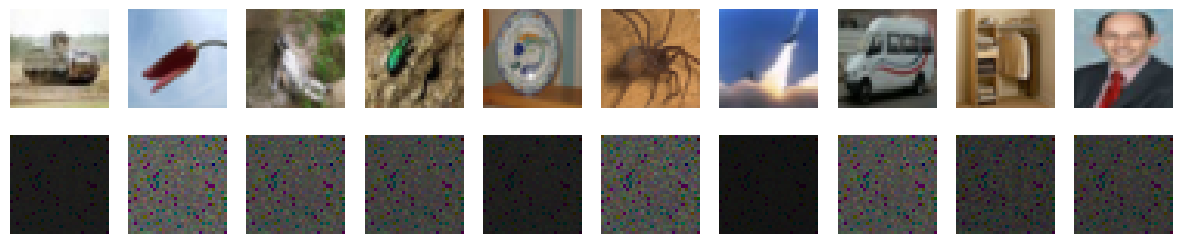

In [169]:
show_reconstructions(variational_ae, X_valid)

### Copyright 2022 PT. Agriaku Digital Indonesia
* You may NOT use this file except there is written permission from AgriAku.
* Any questions can be address to `nicholas.dominic@agriaku.com`.